# Investigating Many Policy Scenarios

In this notebook, we investigate a number of different scenarios. This has been streamlined with a few helper functions:

- `scenario_ds()`: provides a datastructure in which to develop the new scenario
- `read_ds()`: provides a datastructure use for investigating results

These functions are used as follows:

```
with function(<arguments>) as ds:
   <do things with the datastructure
```

All of the opening, closing, running, and committing actions are handled for you. Your job is to concentrate on identifying and updating the scenario variables and then investigating the results.

You can, of course, get the datastructure as you have previously as well.

## Setup and Helper Variables

In [1]:
# load required packages 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from ixmp import ixPlatform
from tools import Plots, scenario_ds, read_ds

In [2]:
# launch the IX modeling platform using the local default database                                                                                                                       
mp = ixPlatform(dbtype='HSQLDB') # use dbtype='HSQLDB' for a local database

In [3]:
country = 'Austria'
horizon = range(2010, 2041, 10)

plants = [
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "bio_ppl", 
    "hydro_ppl",
    "wind_ppl", 
    "solar_pv_ppl", # actually primary -> final
]

lights = [
    "bulb", 
    "cfl", 
]

name = "Austrian energy model"
base_scen = "baseline"

# Wind Subsidies

Rerun the wind subsidy scenario using this framework.

In [4]:
new_scen = 'wind_subsidies'

subsidies = np.array([0.5, 0.5, 0.75, 1.0])
inv_cost = pd.DataFrame({
        'node_loc': country,
        'year_vtg': horizon,
        'technology': 'wind_ppl',
        'value': 1100 * subsidies * 1e6,
        'unit': 'USD/GWa',
})

with scenario_ds(mp, country, name, base_scen, new_scen) as ds:
    ds.add_par('inv_cost', inv_cost)

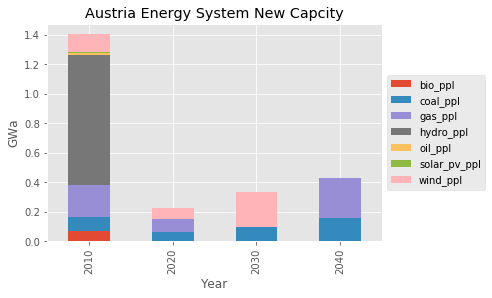

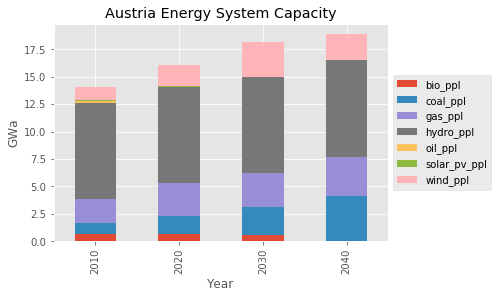

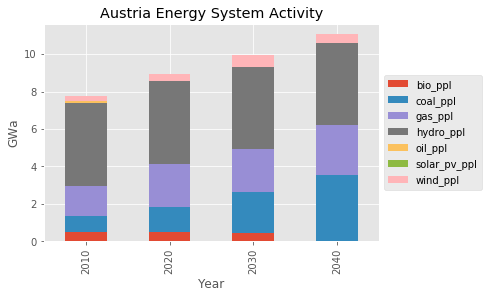

In [5]:
with read_ds(mp, name, new_scen) as ds:
    p = Plots(ds, country)
    p.plot_new_capacity(baseyear=True, subset=plants)
    p.plot_capacity(baseyear=True, subset=plants)
    p.plot_activity(baseyear=True, subset=plants)

# Demand-Side Learning

This model does not use `cfl`s in the basline because they are too expensive. What happens if their cost reduces with time?

In [6]:
new_scen = 'cheap_cfls'

costs = np.array([1.0, 0.6, 0.3, 0.1])
inv_cost = pd.DataFrame({
        'node_loc': country,
        'year_vtg': horizon,
        'technology': 'cfl',
        'value': 900 * costs * 1e6,
        'unit': 'USD/GWa',
})

with scenario_ds(mp, country, name, base_scen, new_scen) as ds:
    ds.add_par('inv_cost', inv_cost)

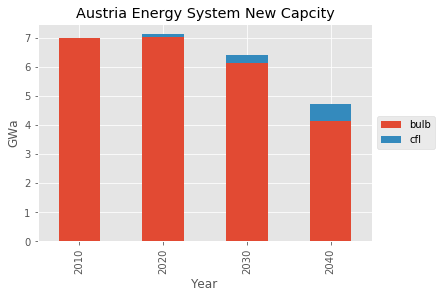

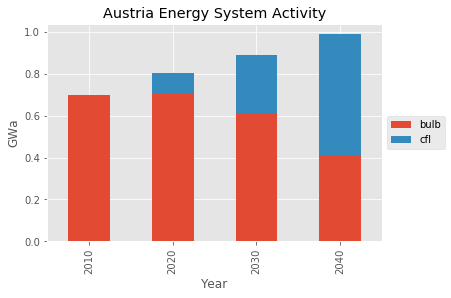

In [7]:
with read_ds(mp, name, new_scen) as ds:
    p = Plots(ds, country)
    p.plot_new_capacity(baseyear=True, subset=lights)
    p.plot_activity(baseyear=True, subset=lights)

# Exercise: Economic Assumptions

What is the effect of assuming a different interest rate? What if it is higher than the baseline? Lower? How does this affect prices?

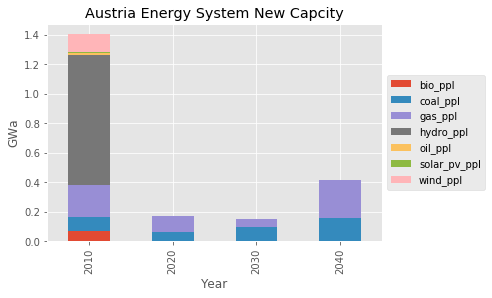

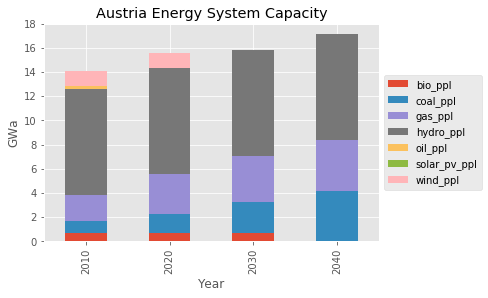

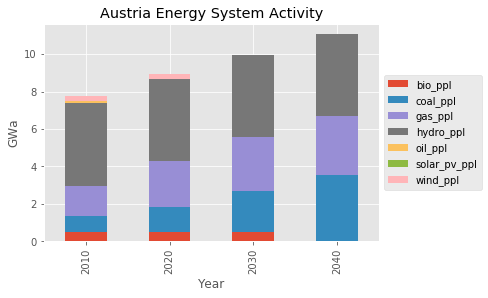

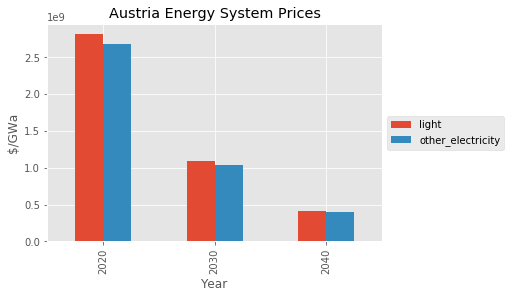

In [8]:
new_scen = 'interest_rate_.1'

with scenario_ds(mp, country, name, base_scen, new_scen) as ds:
    ds.add_par("interestrate", key=horizon, val=[.1] * len(horizon), unit=['%'] * len(horizon))
    
with read_ds(mp, name, new_scen) as ds:
    p = Plots(ds, country)
    p.plot_new_capacity(baseyear=True, subset=plants)
    p.plot_capacity(baseyear=True, subset=plants)
    p.plot_activity(baseyear=True, subset=plants)
    p.plot_prices(baseyear=False, subset=['light', 'other_electricity'])

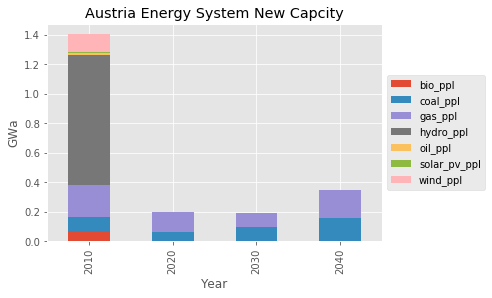

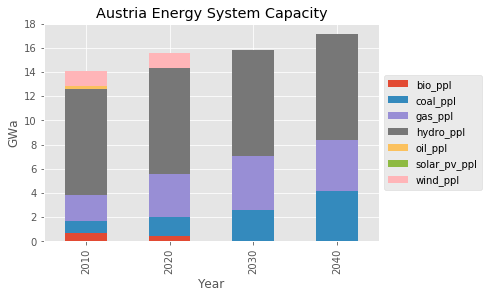

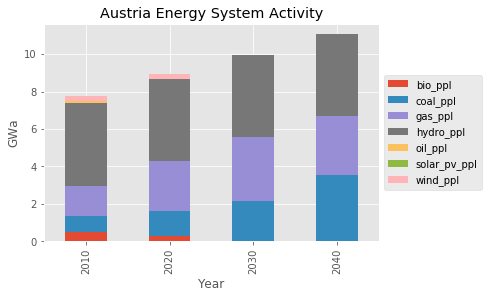

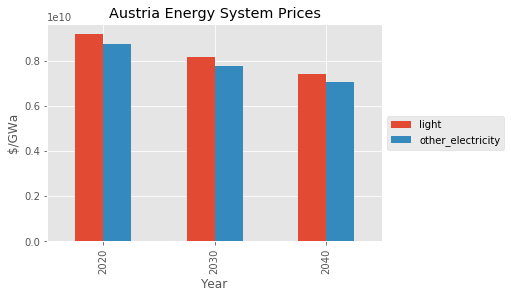

In [9]:
new_scen = 'interest_rate_.01'

with scenario_ds(mp, country, name, base_scen, new_scen) as ds:
    ds.add_par("interestrate", key=horizon, val=[.01] * len(horizon), unit=['%'] * len(horizon))
    
with read_ds(mp, name, new_scen) as ds:
    p = Plots(ds, country)
    p.plot_new_capacity(baseyear=True, subset=plants)
    p.plot_capacity(baseyear=True, subset=plants)
    p.plot_activity(baseyear=True, subset=plants)
    p.plot_prices(baseyear=False, subset=['light', 'other_electricity'])

# Exercise: Carbon Tax

What effect does a carbon tax have on the system? What if it is phased in over time? What is the effect on energy prices?

Hints:

- what emissions parameters are available from `ds.par_list()`?
- find out which fields are required using `ds.idx_names(par_name)`
- carbon taxes are normally provided in units of USD/tCO2
- a normal proposed carbon tax is ~30 USD/tCO2

In [10]:
new_scen = 'carbon_tax'

taxes = pd.DataFrame({
        'node': country,
        'type_emission': 'GHGs',
        'type_year': horizon,
        'type_tec': 'all',
        'value': np.array([0.0, 20.0, 30., 40.]),
        'unit': 'USD/tCO2', 
})

with scenario_ds(mp, country, name, base_scen, new_scen) as ds:
    ds.add_par('tax_emission', taxes)

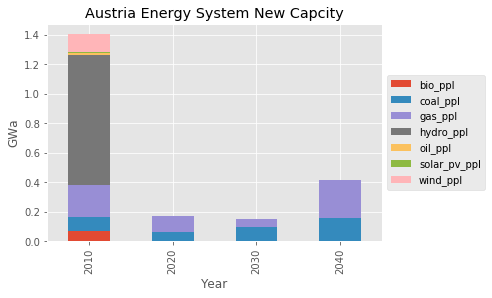

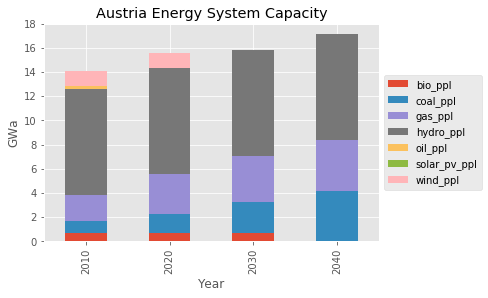

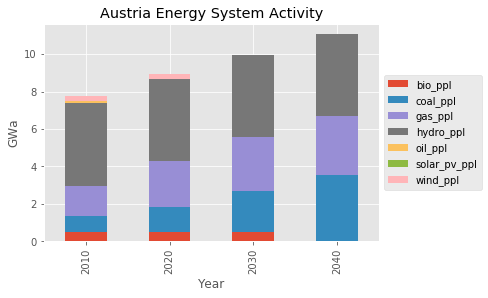

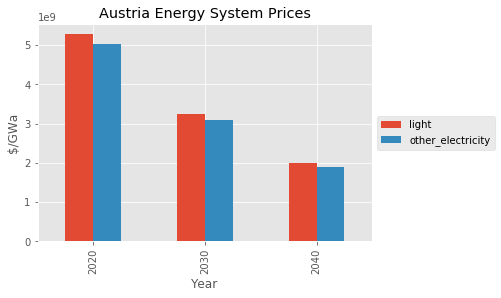

In [11]:
with read_ds(mp, name, new_scen) as ds:
    p = Plots(ds, country)
    p.plot_new_capacity(baseyear=True, subset=plants)
    p.plot_capacity(baseyear=True, subset=plants)
    p.plot_activity(baseyear=True, subset=plants)
    p.plot_prices(baseyear=False, subset=['light', 'other_electricity'])